<a href="https://colab.research.google.com/github/abhayraghuwanshi/Sentiment_classification/blob/main/sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base_directory = "/content/drive/My Drive/stanfordSentimentTreebank"

In [3]:
def sentence_with_split_label(base_directory):
  """
  arg:
    base_directory: str. current directory path
  Return:
    DataFrame: datasetsentences along with the split levels
  """
  dataset_sentences = pd.read_csv(os.path.join(base_directory, "datasetSentences.txt"), sep="\t").set_index('sentence_index')
  data_split_label = pd.read_csv(os.path.join(base_directory, "datasetSplit.txt"), sep=",").set_index('sentence_index')
  dataset_with_label = pd.concat([dataset_sentences, data_split_label], axis=1)
  dataset_with_label["splitset_label"] = dataset_with_label["splitset_label"].fillna(1).astype(int)
  return dataset_with_label


In [6]:
sentence_with_split_label(base_directory)

,sentence,splitset_label
sentence_index,,
1,The Rock is destined to be the 21st Century 's...,1
2,The gorgeously elaborate continuation of `` Th...,1
3,Effective but too-tepid biopic,2
4,If you sometimes like to go to the movies to h...,2
5,"Emerges as something rare , an issue movie tha...",2
...,...,...
11851,A real snooze .,1
11852,No surprises .,1
11853,We 've seen the hippie-turned-yuppie plot befo...,1


In [7]:
def sentiment_to_class(sentmnt):
  """
    Arg:
      sentimnt : int.     
    Return:
      int. classifying the sentiment according to the sentmnt value.
  """
  if(sentmnt <= 0.2):
      return 0
  elif(sentmnt <= 0.4):
      return 1
  elif(sentmnt <= 0.6):
      return 2
  elif(sentmnt <= 0.8):
      return 3
  else:
      return 4

In [8]:
def dictionary_with_sentiment_value(base_directory):
  """
  Arg:
    base_directory : str. 
  Return:
    pandas Dataframe with sentiment value corresponding to the each phrase
  
  """
  #imports of the data standford data
  sentiment_labels = pd.read_csv(os.path.join(base_directory, "sentiment_labels.txt"), sep="|")
  dictionary = pd.read_csv(os.path.join(base_directory, "dictionary.txt"), sep="|")
  sentiment_labels.columns = ["phrase_id", "sentiment_value"]
  # applying the function sentiment_to_class 
  sentiment_labels["sentiment_value"] = sentiment_labels["sentiment_value"].apply(sentiment_to_class)
  dictionary.columns = ["phrase", "phrase_id"]
  # Joining the dataframe sentiment_lable and the dictionary with the phrase_id as common column
  dictionary_with_sentiment = dictionary.join(sentiment_labels.set_index("phrase_id"), on="phrase_id")
  return dictionary_with_sentiment

In [9]:
def dataset_with_sentiment(base_directory):
  """
  preprocess the data by adding sentence values to all the sentences.
  
  Arg:
    base_directory : str. 
  Return:
    pandas Dataframe with sentiment value corresponding to the each phrase
  """
  dataset_with_label = sentence_with_split_label(base_directory)
  dictionary_with_sentiment = dictionary_with_sentiment_value(base_directory)
  dataset = dataset_with_label.join(dictionary_with_sentiment.set_index("phrase"), on="sentence")
  dataset["sentence"] = dataset["sentence"].str.replace(r"\s('s|'d|'re|'ll|'m|'ve|n't)\b", lambda m: m.group(1))
  return dataset

In [10]:
dataset = dataset_with_sentiment(base_directory)

In [12]:
dataset = dataset.dropna(0)#drop the rows missing from the dataset

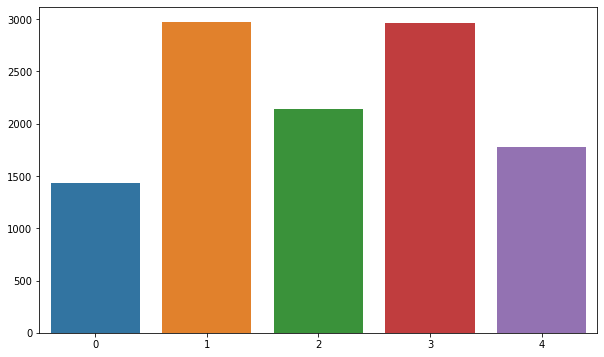

In [13]:
#representation of the count of the particular sentiment
import matplotlib.pyplot as plt
import seaborn  as sns
count_sentiment_value = map(lambda x: len(dataset[dataset["sentiment_value"]==x]), [0., 1., 2., 3., 4.])
plt.figure(figsize=(10,6))
sns.barplot(x=[0,1,2,3,4], y= list(count_sentiment_value))

# <h1> LSTM Model with the preprocessing</h1>

In [14]:
from keras.utils import to_categorical
import random
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

In [15]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
from tqdm import tqdm

In [16]:
test_data = pd.read_csv(os.path.join(base_directory, "mobile_review.csv"))

In [17]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   phone_name  3000 non-null   object
 1   review      3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


In [21]:
def clean_phone_name(name):
  #remove the additional info from the phone name
  x = name.find("(")
  return name[0:x]

In [22]:
test_data["phone_name"] = test_data["phone_name"].apply(clean_phone_name)

In [23]:
def clean_sentences(df):
    """
    Arg:
      df:dataframe. The sentence column of the data
    Return:
      list of list of words in sentences.
    """
    reviews = []

    for sent in tqdm(df):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [26]:
 nltk.download('wordnet')
 nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
train = clean_sentences(dataset["sentence"])

100%|██████████| 11286/11286 [00:07<00:00, 1567.97it/s]


In [28]:
test = clean_sentences(test_data["review"])

100%|██████████| 3000/3000 [00:02<00:00, 1101.55it/s]


In [31]:
target = dataset["sentiment_value"] #extracting the sentiment value from the dataset
y_target=to_categorical(target) # convert it into categorical in the shape of [0,0,0,0,1]
num_classes=y_target.shape[1]

In [32]:
X_train,X_val,y_train,y_val=train_test_split(train,y_target,test_size=0.2,stratify=y_target)

In [39]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent) # update the set with the list in the sent.
    
    if(len_max<len(sent)):
        len_max = len(sent)

100%|██████████| 9028/9028 [00:00<00:00, 351867.09it/s]


In [40]:
print(len(list(unique_words)))
print(len_max)

13916
52


<h3> Tokenizing</h3>

In [41]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
x_train_list = list(X_train)
tokenizer.fit_on_texts(list(x_train_list))

#texts_to_sequences(texts)

# Arguments- texts: list of texts to turn to sequences.
  #Return: list of sequences (one per text input).
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test)

<h3> Padding</h3>

In [42]:
#LSTM need all the inputs of same size so, padding help us to make it to same size.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=int(len_max))
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

In [43]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [44]:
#Model using Keras LSTM

#Multilayer Perceptron (MLP) for multi-class softmax classification:
#Let’s build what’s probably the most popular type of model in NLP at the moment: Long Short Term Memory network. 
#This architecture is specially designed to work on sequence data.
#It fits perfectly for many NLP tasks like tagging and text classification.
#It treats the text as a sequence rather than a bag of words or as ngrams.

#Here’s a possible model definition:

model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 52, 300)           4174800   
_________________________________________________________________
lstm (LSTM)                  (None, 52, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 4,450,861
Trainable params: 4,450,861
Non-trainable params: 0
______________________________________________

In [46]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=10, batch_size=256, verbose=1, callbacks=callback)

Epoch 1/10
36/36 [==============================] - 40s 1s/step - loss: 1.4842 - accuracy: 0.3435 - val_loss: 1.3858 - val_accuracy: 0.3809
Epoch 2/10
36/36 [==============================] - 39s 1s/step - loss: 1.1708 - accuracy: 0.5053 - val_loss: 1.3762 - val_accuracy: 0.4061
Epoch 3/10
36/36 [==============================] - 39s 1s/step - loss: 0.8494 - accuracy: 0.6649 - val_loss: 1.5426 - val_accuracy: 0.3977
Epoch 4/10
36/36 [==============================] - 39s 1s/step - loss: 0.5934 - accuracy: 0.7875 - val_loss: 1.7824 - val_accuracy: 0.3756
Epoch 5/10
36/36 [==============================] - 39s 1s/step - loss: 0.4010 - accuracy: 0.8612 - val_loss: 2.2592 - val_accuracy: 0.3689
Epoch 6/10
36/36 [==============================] - 39s 1s/step - loss: 0.2736 - accuracy: 0.9060 - val_loss: 2.4049 - val_accuracy: 0.3782
Epoch 7/10
36/36 [==============================] - 39s 1s/step - loss: 0.2063 - accuracy: 0.9317 - val_loss: 2.9037 - val_accuracy: 0.3733
Epoch 8/10
36/36 [==

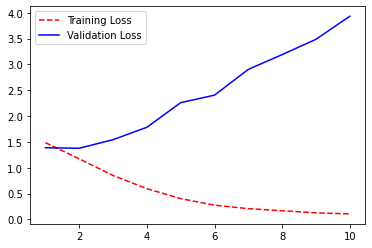

In [48]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])


In [49]:
pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [50]:
len(pred)

3000

In [51]:
phone_review_with_pred = pd.concat([test_data, pd.DataFrame(pred, columns=["pred"])], axis=1)

In [52]:
phone_review_with_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   phone_name  3000 non-null   object
 1   review      3000 non-null   object
 2   pred        3000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 70.4+ KB


In [53]:
phone_review_with_pred.head()

,phone_name,review,pred
0,Redmi 8A Dual,\n\n Defective product shipped.. reported wi...,3
1,Redmi 8A Dual,\n\n Nice phone camera better attractive look...,3
2,Redmi 8A Dual,\n\n Design-GoodCamera-NiceDisplay-satisfacto...,3
3,Redmi 8A Dual,\n\n The headphone jack is not working 😡 Des...,2
4,Redmi 8A Dual,"\n\n First sell, First order. Mobile is very ...",1


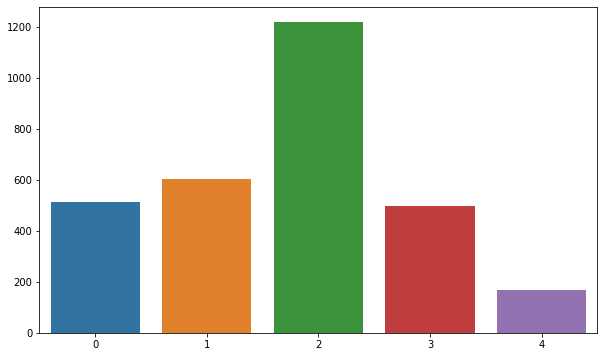

In [54]:
count_sentiment_value = map(lambda x: len(phone_review_with_pred[phone_review_with_pred["pred"]==x]), [0., 1., 2., 3., 4.])
plt.figure(figsize=(10,6))
sns.barplot(x=[0,1,2,3,4], y= list(count_sentiment_value))

In [56]:
phone_review_with_pred.to_excel("mobile_phones_1.xlsx",columns=["phone_name", "review", "pred"],  index=False)

In [57]:
phone_review_with_pred.to_csv("mobile_phones_final.csv",columns=["phone_name", "review", "pred"],  index=False)

altering different hyper parameters especially learning rate can have a positive impact
on accuracy and learning curve. model has low accuracy now but if i had more time to do it then result might be a little bit different.